In [1]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, LSTM
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.optimizers import Adam
from keras.models import Sequential
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import concatenate
from keras.callbacks import *
from keras.utils import to_categorical


Using TensorFlow backend.


In [2]:
import keras
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)

keras.backend.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
#google word2vec
from gensim.models import KeyedVectors as wv
word_vectors = wv.load_word2vec_format('./input/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin', binary = True)
EMBEDDING_DIM =300

##glove
# embeddings_index = {}
# f = open(os.path.join(GLOVE_DIR, './input/embeddings/glove.840B.300d/glove.840B.300d.txt'))
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()
# EMBEDDING_DIM =300

# print('Found %s word vectors.' % len(embeddings_index))

In [4]:
df_train = pd.read_csv("./input/train.csv")
df_test = pd.read_csv("./input/test.csv")
print("Train shape : ",df_train.shape)
print("Test shape : ",df_test.shape)

df_train_pos = df_train[df_train['target']==1]
df_train_neg = df_train[df_train['target']==0].sample(len(df_train_pos)*2,random_state=1)
df_train = pd.concat([df_train_pos,df_train_neg])
df_train = df_train.sample(frac=1,random_state=1)
print("Train shape : ",df_train.shape)

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

MAX_SEQUENCE_LENGTH=150


tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(df_train['question_text'])
sequences = tokenizer.texts_to_sequences(df_train['question_text'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

train_X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
train_Y = df_train['target']
# labels = to_categorical(np.asarray(labels))
# print('Shape of data tensor:', data.shape)
# print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
# indices = np.arange(data.shape[0])
# np.random.shuffle(indices)
# data = data[indices]
# labels = labels[indices]
# nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

# x_train = data[:-nb_validation_samples]
# y_train = labels[:-nb_validation_samples]
# x_val = data[-nb_validation_samples:]
# y_val = labels[-nb_validation_samples:]

Train shape :  (1306122, 3)
Test shape :  (56370, 2)
Train shape :  (242430, 3)
Found 102901 unique tokens.


In [5]:

df_train.iloc[4]['question_text']

'Why do some followers of Jainism roam naked and no one beat them?'

78.44606690591098
65.0
45.79357529027139
1017


(array([1.87777e+05, 4.78110e+04, 6.83700e+03, 3.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([1.000e+00, 1.026e+02, 2.042e+02, 3.058e+02, 4.074e+02, 5.090e+02,
        6.106e+02, 7.122e+02, 8.138e+02, 9.154e+02, 1.017e+03]),
 <a list of 10 Patch objects>)

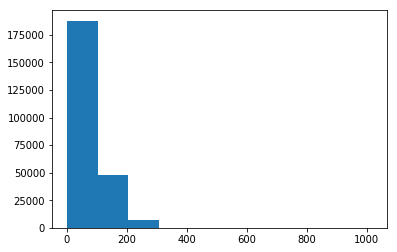

In [6]:
lengths = []
for sent in df_train['question_text']:
#     print(sent)
    lengths.append(len(sent))
#     if max(sent)>50:
#         print(sent)
print(np.mean(lengths))
print(np.median(lengths))
print(np.std(lengths))
print(np.max(lengths))
plt.hist(lengths,density=False)

In [7]:
#for google word2vec

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        word_vector = word_vectors[word]
#     if word_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = word_vector
    except KeyError:
        continue

In [8]:
# print(train_X_raw[0])
print(train_X.shape)
print(train_Y.shape)
# print(tokenizer.word_index)

(242430, 150)
(242430,)


In [9]:
def f1(y_true, y_pred):
    '''
    metric from here 
    https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
    '''
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    # So we only measure F1 on the target y value:
    y_true = y_true[:, 0]
    y_pred = y_pred[:, 0]
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [10]:
##model definition
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))


# model.add(CuDNNLSTM(75, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Bidirectional(CuDNNLSTM(150, return_sequences=True), input_shape=(train_X.shape[1], EMBEDDING_DIM)))
model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(Dense(1, activation='relu'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 300)          30870600  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 300)          542400    
_________________________________________________________________
flatten_1 (Flatten)          (None, 45000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               4500100   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 35,913,201
Trainable params: 5,042,601
Non-trainable params: 30,870,600
_________________________________________________________________
None


In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1])  

In [ ]:
model.fit(train_X, train_Y, epochs=100,batch_size=500,validation_split=0.2)

Train on 193944 samples, validate on 48486 samples
Epoch 1/100
193944/193944 [==============================] - 49s 251us/step - loss: 0.4325 - acc: 0.8412 - f1: 0.7536 - val_loss: 0.3386 - val_acc: 0.8701 - val_f1: 0.7953
Epoch 2/100
193944/193944 [==============================] - 46s 238us/step - loss: 0.3846 - acc: 0.8539 - f1: 0.7820 - val_loss: 0.3671 - val_acc: 0.8407 - val_f1: 0.7137
Epoch 3/100
193944/193944 [==============================] - 47s 243us/step - loss: 0.4332 - acc: 0.8437 - f1: 0.7380 - val_loss: 0.3583 - val_acc: 0.8681 - val_f1: 0.7973
Epoch 4/100
193944/193944 [==============================] - 48s 246us/step - loss: 0.3425 - acc: 0.8653 - f1: 0.7997 - val_loss: 0.3618 - val_acc: 0.8695 - val_f1: 0.8197
Epoch 5/100
193944/193944 [==============================] - 49s 251us/step - loss: 0.3672 - acc: 0.8554 - f1: 0.7793 - val_loss: 0.3708 - val_acc: 0.8663 - val_f1: 0.7789
Epoch 6/100
193944/193944 [==============================] - 49s 251us/step - loss: 0.341

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten

model=Sequential()
model.add(Conv2D(10,(3,3)))
model.add(Conv2D(10,(3,3)))
model.add(Flatten())
model.add(Dense(20))
model.add(Dense(10))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
# model.build()
# model.summary()

In [ ]:
import tensorflow as tf; print(tf.__version__)
import keras; print(keras.__version__)

In [ ]:
def load_glove(word_index):
    EMBEDDING_FILE = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 

In [ ]:
import string
letter_count = dict(zip(string.ascii_lowercase, [0]*26))

In [ ]:
{chr(i+96):i for i in range(1,27)}